In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt

In [3]:
# From: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of properties dataframe is :", start_mem_usg, " MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            IsInt = False

            mx = props[col].max()
            mn = props[col].min()

            if not np.isfinite(props[col]).all():
                props[col].fillna(-999, inplace=True)

            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()

            if -0.01 < result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)
            else:
                props[col] = props[col].astype(np.float32)

    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage is: ", mem_usg, " MB")
    print("This is ", 100 * mem_usg / start_mem_usg, "% of the initial size")
    return props

def load_csv(path):
    return reduce_mem_usage(pd.read_csv(path))

In [5]:
train_transaction =  load_csv("train_transaction.csv")


Memory usage of properties dataframe is : 1775.1524047851562  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  450.54638671875  MB
This is  25.38071579117619 % of the initial size


In [6]:
train_identity =   load_csv("train_identity.csv")

Memory usage of properties dataframe is : 45.11695098876953  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  23.934049606323242  MB
This is  53.04890752099113 % of the initial size


In [7]:
trainset = pd.merge(train_transaction, train_identity, on='TransactionID', how='outer')
%reset_selective -f train_transaction
%reset_selective -f train_identity

In [8]:
trainset.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)

In [9]:
trainset = trainset[["TransactionID","DeviceType","DeviceInfo","TransactionDT","TransactionAmt","ProductCD","card4","card6","P_emaildomain","R_emaildomain","addr1","addr2","dist1","dist2","isFraud"]]

In [10]:
trainset.iloc[:5]

,TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2,isFraud
0,2987000,NaN,NaN,86400,68.5,W,discover,credit,NaN,NaN,315,87,19,64537,0
1,2987001,NaN,NaN,86401,29.0,W,mastercard,credit,gmail.com,NaN,325,87,64537,64537,0
2,2987002,NaN,NaN,86469,59.0,W,visa,debit,outlook.com,NaN,330,87,287,64537,0
3,2987003,NaN,NaN,86499,50.0,W,mastercard,debit,yahoo.com,NaN,476,87,64537,64537,0
4,2987004,mobile,SAMSUNG SM-G892A Build/NRD90M,86506,50.0,H,mastercard,credit,gmail.com,NaN,420,87,64537,64537,0


In [11]:
trainset.groupby('isFraud').agg([np.mean, np.median])

TransactionID          TransactionDT          TransactionAmt         \
                 mean   median          mean   median           mean median   
isFraud                                                                       
0        3.281810e+06  3281808  7.360791e+06  7271678     134.511658   68.5   
1        3.294952e+06  3291934  7.690033e+06  7575230     149.244781   75.0   

                addr1             addr2                dist1         \
                 mean median       mean median          mean median   
isFraud                                                               
0         6825.457106    299  80.526252     87  38140.272650  64537   
1        24361.616561    337  63.326380     87  49725.827131  64537   

                dist2         
                 mean median  
isFraud                       
0        60712.360962  64537  
1        52920.300876  64537

In [12]:
trainset['TransactionDT_day'] = trainset['TransactionDT'].apply(lambda x: int(x/86400))
trainset['TransactionDT_hour'] = trainset['TransactionDT'].apply(lambda x: int(x/86400%1*24))
trainset['TransactionDT_min'] = trainset['TransactionDT'].apply(lambda x: int(x/86400%1*24%1*60))
trainset['TransactionDT_sec'] = trainset['TransactionDT'].apply(lambda x: int(x/86400%1*24%1*60%1*60))

Question 1
----------

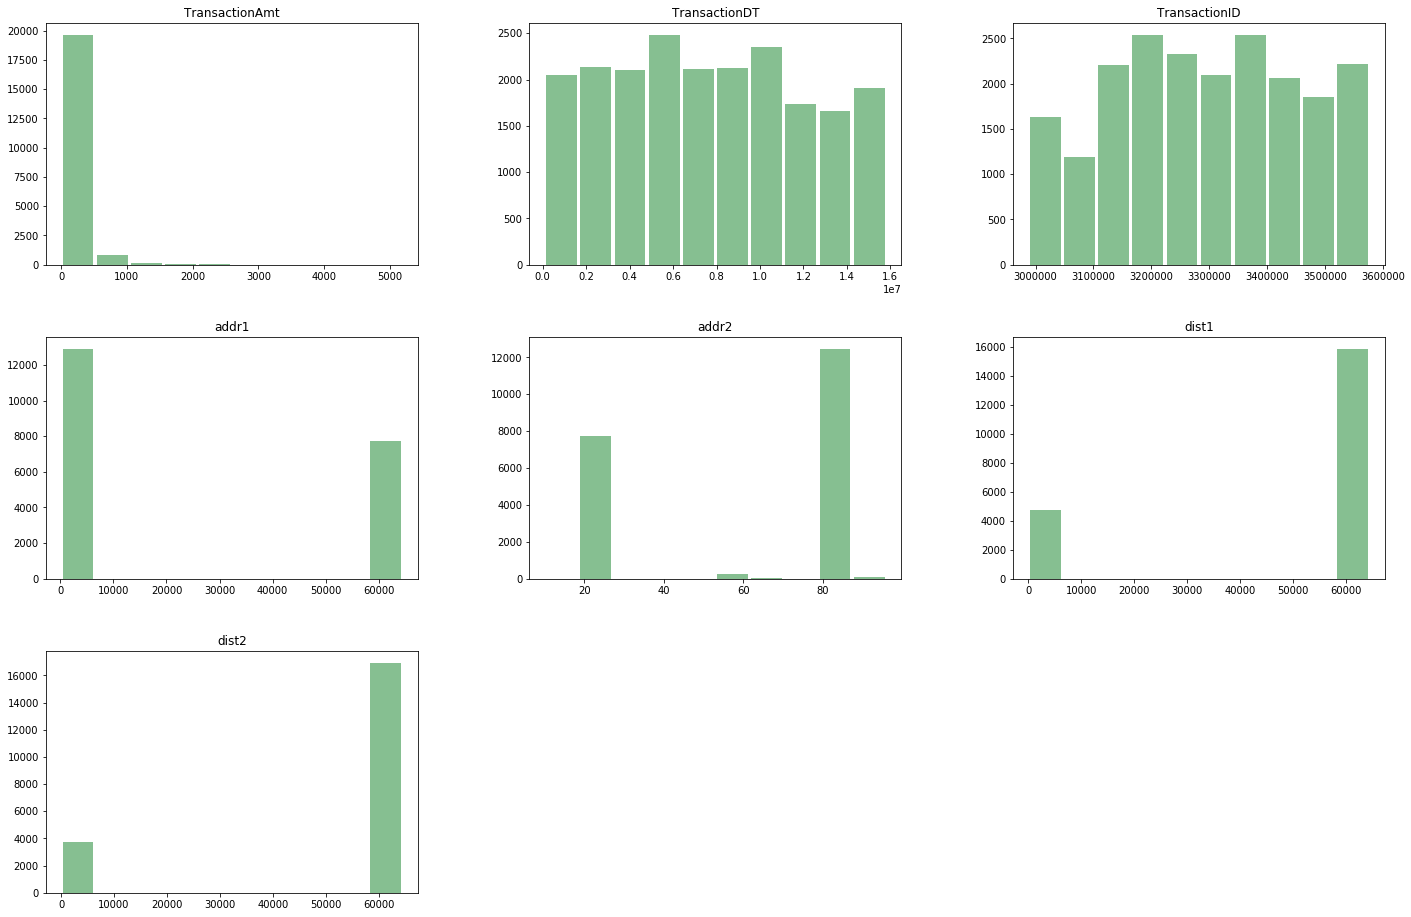

In [13]:
hist0 = trainset[trainset['isFraud'] == True][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].hist(grid=False, figsize=(24,16), color='#86bf91', zorder=2, rwidth=0.9)

In [14]:
trainset[trainset['isFraud'] == True][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2
count,2.066300e+04,2.066300e+04,20663.000000,20663.000000,20663.000000,20663.000000,20663.000000
mean,3.294952e+06,7.690033e+06,149.247192,24361.616561,63.326380,49725.827131,52920.300876
std,1.620403e+05,4.416551e+06,232.210709,31096.084793,29.920565,27092.229234,24748.438840
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000
25%,3.167366e+06,3.965858e+06,35.043999,269.000000,25.000000,64537.000000,64537.000000
50%,3.291934e+06,7.575230e+06,75.000000,337.000000,87.000000,64537.000000,64537.000000
75%,3.428646e+06,1.121743e+07,161.000000,64537.000000,87.000000,64537.000000,64537.000000
max,3.577526e+06,1.581088e+07,5191.000000,64537.000000,96.000000,64537.000000,64537.000000


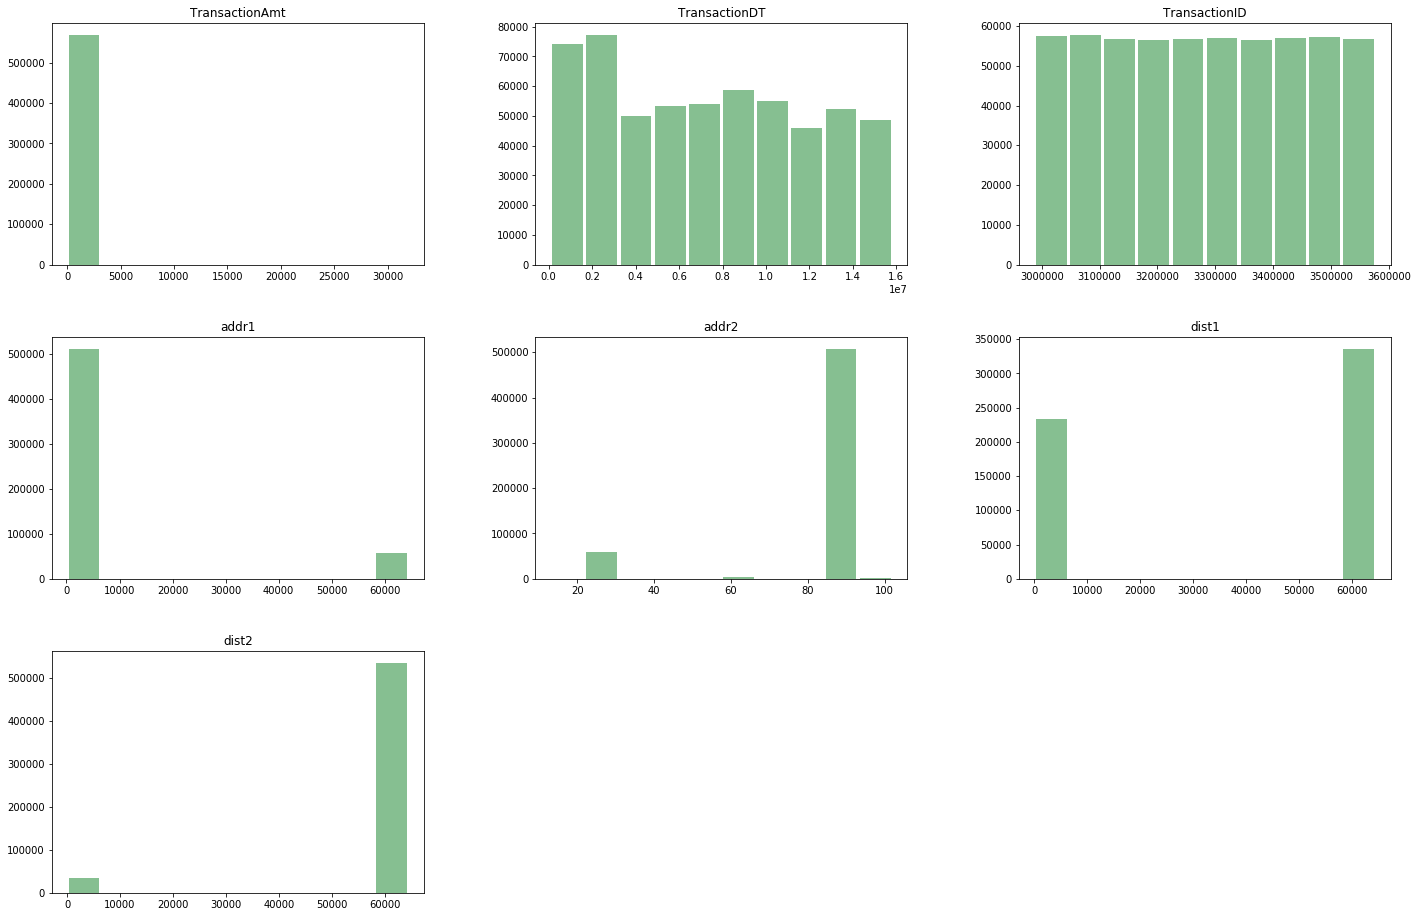

In [15]:
hist0 = trainset[trainset['isFraud'] == False][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].hist(grid=False, figsize=(24,16), color='#86bf91', zorder=2, rwidth=0.9)

In [16]:
trainset[trainset['isFraud'] == False][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2
count,5.698770e+05,5.698770e+05,569877.000000,569877.000000,569877.000000,569877.00000,569877.000000
mean,3.281810e+06,7.360791e+06,134.340332,6825.457106,80.526252,38140.27265,60712.360962
std,1.707548e+05,4.623930e+06,239.398010,19420.199179,18.847367,31681.83246,15209.235886
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.00000,0.000000
25%,3.133317e+06,3.010651e+06,43.970001,204.000000,87.000000,12.00000,64537.000000
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,64537.00000,64537.000000
75%,3.429974e+06,1.125334e+07,120.000000,420.000000,87.000000,64537.00000,64537.000000
max,3.577539e+06,1.581113e+07,31937.390625,64537.000000,102.000000,64537.00000,64537.000000


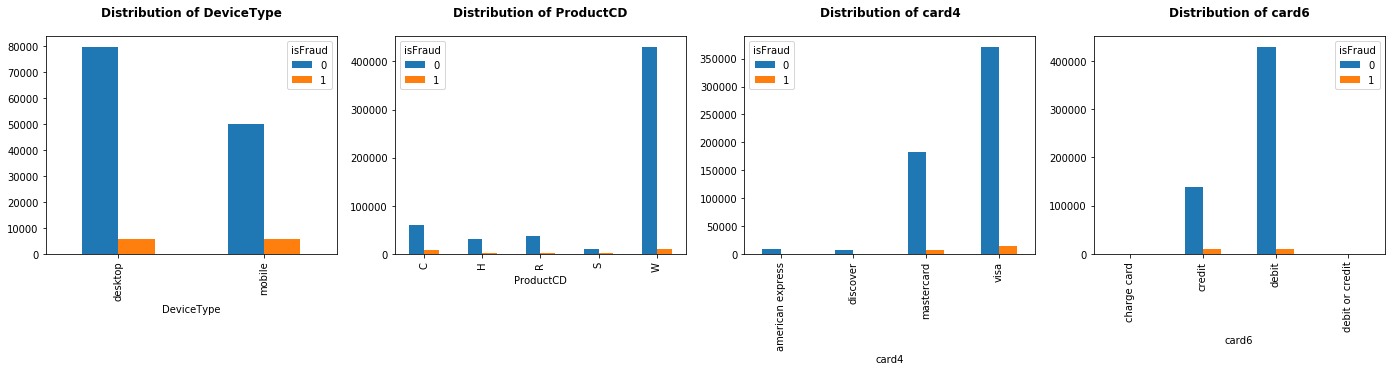

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(24, 4))

for i, column in enumerate(["DeviceType","ProductCD","card4","card6"]):
    pd.crosstab(trainset[column], trainset.isFraud).plot(kind='bar', ax=axes[i])
    axes[i].set_title("Distribution of " + column, pad=20, fontweight='bold', fontsize=12)

In [18]:
trainset.groupby('isFraud')['DeviceInfo'].value_counts()

isFraud  DeviceInfo 
0        Windows        44601
         iOS Device     18542
         MacOS          12295
         Trident/7.0     7344
         rv:11.0         1825
                        ...  
1        iPhone             1
         rv:29.0            1
         rv:45.0            1
         rv:52.9            1
         rv:61.0            1
Name: DeviceInfo, Length: 2160, dtype: int64

Question 2
----------

In [19]:
most_freq_country_code = trainset['addr2'].value_counts().idxmax()
addr2_set = trainset[trainset['addr2'] == most_freq_country_code]

In [20]:
addr2_set['TransactionDT'][60000:60005]

67055    1528548
67056    1528563
67057    1528580
67058    1528587
67059    1528589
Name: TransactionDT, dtype: uint32

In [21]:
addr2_set.iloc[60000:60005]

,TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2,isFraud,TransactionDT_day,TransactionDT_hour,TransactionDT_min,TransactionDT_sec
67055,3054055,mobile,iOS Device,1528548,150.000000,H,mastercard,credit,gmail.com,gmail.com,126,87,64537,64537,0,17,16,35,48
67056,3054056,NaN,NaN,1528563,107.949997,W,discover,credit,hotmail.com,NaN,436,87,2,64537,0,17,16,36,2
67057,3054057,NaN,NaN,1528580,94.949997,W,mastercard,debit,aol.com,NaN,315,87,64537,64537,0,17,16,36,19
67058,3054058,NaN,NaN,1528587,29.000000,W,mastercard,debit,gmail.com,NaN,269,87,1,64537,0,17,16,36,26
67059,3054059,NaN,NaN,1528589,261.950012,W,mastercard,debit,verizon.net,NaN,494,87,1,64537,0,17,16,36,28


Text(0, 0.5, 'Number of Transactions')

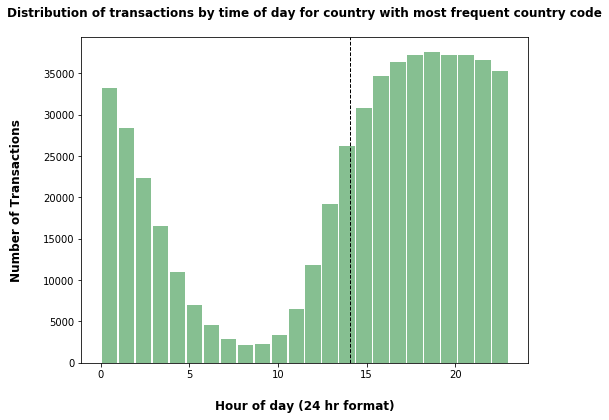

In [22]:
hist1 = addr2_set['TransactionDT_hour'].hist(bins=24, grid=False, figsize=(8,6), color='#86bf91', zorder=2, rwidth=0.9)
hist1.axvline(addr2_set['TransactionDT_hour'].mean(), color='k', linestyle='dashed', linewidth=1)

hist1.set_title("Distribution of transactions by time of day for country with most frequent country code", pad=20, fontweight='bold', fontsize=12)

hist1.set_xlabel("Hour of day (24 hr format)", labelpad=20, weight='bold', size=12)
hist1.set_ylabel("Number of Transactions", labelpad=20, weight='bold', size=12)

Question 3
----------

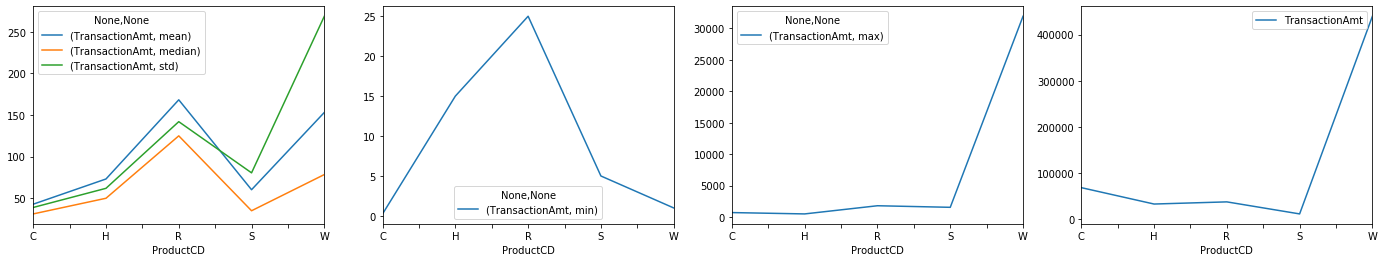

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(24, 4))
trainset[['ProductCD', 'TransactionAmt']].groupby(['ProductCD']).agg([np.mean, np.median, np.std]).plot(ax=axes[0])

trainset[['ProductCD', 'TransactionAmt']].groupby(['ProductCD']).agg([min]).plot(ax=axes[1])

trainset[['ProductCD', 'TransactionAmt']].groupby(['ProductCD']).agg([max]).plot(ax=axes[2])

trainset[['ProductCD', 'TransactionAmt']].groupby(['ProductCD']).count().plot(ax=axes[3])

Question 4
----------

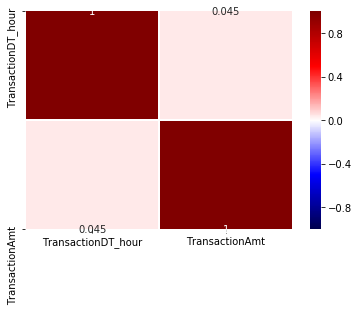

In [24]:
sns.heatmap(trainset[['TransactionDT_hour', 'TransactionAmt']].corr(), vmin=-1, vmax=1, cmap='seismic', linewidths=0.2, annot=True)

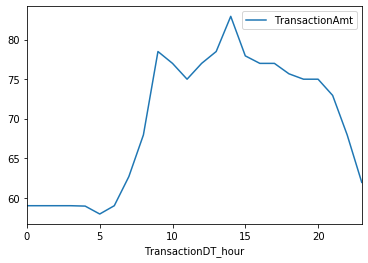

In [25]:
trainset[['TransactionDT_hour', 'TransactionAmt']].groupby(['TransactionDT_hour']).median().plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58e33023d0>]],
      dtype=object)

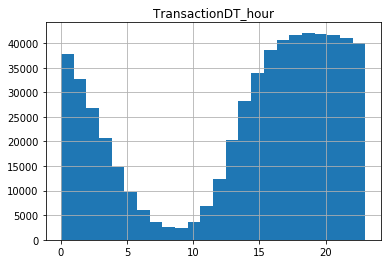

In [26]:
trainset[['TransactionDT_hour']].hist(bins=24)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58e2d44950>]],
      dtype=object)

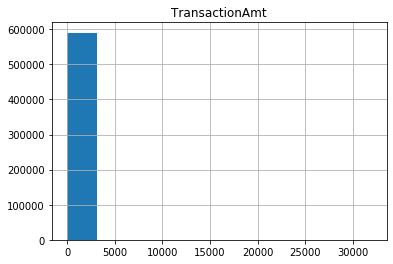

In [27]:
trainset[['TransactionAmt']].hist()

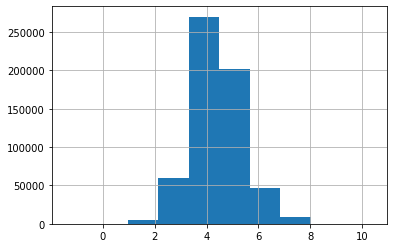

In [28]:
np.log(trainset['TransactionAmt']).hist()

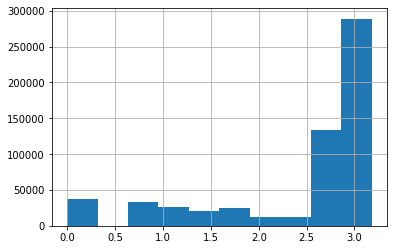

In [29]:
np.log(1 + trainset['TransactionDT_hour']).hist()

Question 5
----------

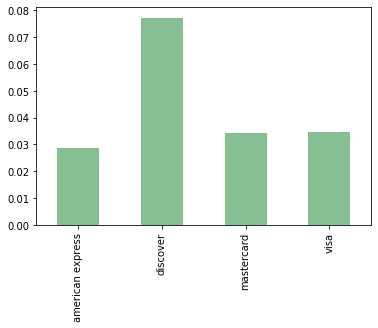

In [30]:
(trainset[trainset['isFraud'] == True]['card4'].value_counts()/trainset['card4'].value_counts()).plot(kind='bar', color='#86bf91')

In [31]:
trainset[trainset['isFraud'] == True].shape[0]/trainset.shape[0]

0.03499000914417313

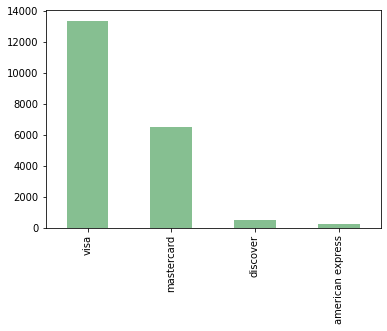

In [32]:
trainset[trainset['isFraud'] == True]['card4'].value_counts().plot(kind='bar', color='#86bf91')

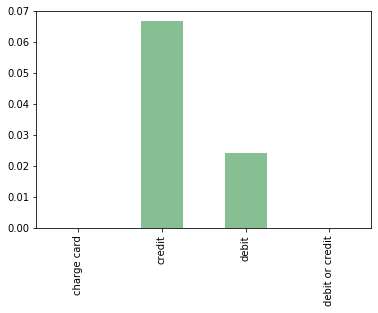

In [33]:
(trainset[trainset['isFraud'] == True]['card6'].value_counts()/trainset['card6'].value_counts()).plot(kind='bar', color='#86bf91')

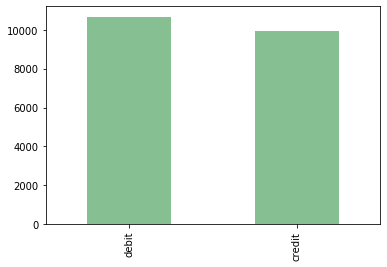

In [34]:
trainset[trainset['isFraud'] == True]['card6'].value_counts().plot(kind='bar', color='#86bf91')

Question 6
----------

### Data Cleaning

In [35]:
# Create a copy of trainset for easy resetting
dataset = trainset.copy()

In [36]:
# Replace columns that have empty value with 'unknown' value
cols = ['card4', 'card6', 'DeviceType', 'DeviceInfo', 'P_emaildomain', 'R_emaildomain']
dataset[cols] = dataset[cols].replace({'': 'unknown'})

In [37]:
# Keep the top 5 column values and group remaining ones into 'Others'
top5_deviceinfo = set(dataset['DeviceInfo'].value_counts()[:5].index)
dataset['DeviceInfo'] = dataset['DeviceInfo'].apply(lambda x: x if x in top5_deviceinfo else 'Others')

In [38]:
# Group categories that are similar into one category [4]
regex_patterns = {
    r'^frontier.*$': 'frontier.com',
    r'^gmail.*$': 'gmail.com',
    r'^hotmail.*$': 'hotmail.com',
    r'^live.*$': 'live.com',
    r'^netzero.*$': 'netzero.com',
    r'^outlook.*$': 'outlook.com',
    r'^yahoo.*$': 'yahoo.com'
}
replacements = {
    'P_emaildomain': regex_patterns,
    'R_emaildomain': regex_patterns
}

dataset.replace(replacements, regex=True, inplace=True)

### Preprocessing
Use sine and cosine for time of the day as these are [$cyclical features^{[3]}$](#References)

In [39]:
dataset['hr_sin'] = np.sin((dataset['TransactionDT_hour'] + dataset['TransactionDT_min']/60.0)*(np.pi/12.0))
dataset['hr_cos'] = np.cos((dataset['TransactionDT_hour'] + dataset['TransactionDT_min']/60.0)*(np.pi/12.0))
dataset['TransactionAmt_lg'] = np.log(dataset['TransactionAmt'])

from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()
dataset['TransactionAmt_scaled'] = rob_scaler.fit_transform(dataset['TransactionAmt'].values.reshape(-1,1))

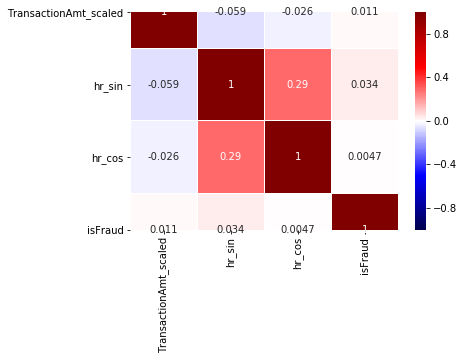

In [40]:
sns.heatmap(dataset[['TransactionAmt_scaled', 'hr_sin', 'hr_cos', 'isFraud']].corr(), vmin=-1, vmax=1, cmap='seismic', linewidths=0.2, annot=True)

In [41]:
categorical_cols = ['DeviceType', 'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']
ohe = pd.get_dummies(dataset[categorical_cols])
ohe.drop('card6_debit or credit', axis=1, inplace=True)
dataset = dataset.join(ohe)

In [42]:
dataset.fillna(value={'addr1': -1.0}, inplace=True)

In [43]:
dataset['addr1_scaled'] = rob_scaler.fit_transform(dataset['addr1'].values.reshape(-1,1))

In [44]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [45]:
train_cols = ["TransactionAmt_scaled","hr_sin","hr_cos","addr1"] + list(ohe.columns)
X, y = dataset[train_cols], dataset['isFraud']

In [46]:
#from imblearn.under_sampling import RandomUnderSampler
#sampler = RandomUnderSampler(random_state=0, sampling_strategy=1.0)

#X_resampled, y_resampled = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [47]:
import wandb

In [48]:
def logisticRegressionClassifier():
    from sklearn.linear_model import LogisticRegression
    print('logisticRegressionClassifier')

    clf = LogisticRegression(solver='lbfgs', max_iter=4000)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)

    print(metrics.classification_report(y_test, preds))
    wandb.log({'accuracy_score': metrics.accuracy_score(y_test,preds)})

    wandb.sklearn.plot_classifier(clf, X_train, X_test, y_train, y_test, preds, pred_prob, clf.classes_,
                                  model_name='LogisticRegression', feature_names=None)


In [69]:
import xgboost as xgb
def xgbClassifier():
    print('xgboost')
    param={}
    xg_train = xgb.DMatrix(X_train, label=y_train)
    xg_test = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    param['objective'] = 'multi:softmax'
    # scale weight of positive examples
    param['eta'] = 0.1
    param['num_class'] = 2
    bst = xgb.train(param, xg_train, 5, watchlist, callbacks=[wandb.xgboost.wandb_callback()])
    preds = bst.predict(xg_test)
    wandb.log({'accuracy_score': metrics.accuracy_score(y_test,preds)})
    #Use sklearn classifier API
    clf = xgb.XGBClassifier(nthread = -1)
    clf.fit(X_train, y_train)
    print("done fitting")
    preds = clf.predict(X_test)
    
    pred_prob=clf.predict_proba(X_test)
    
    
    wandb.sklearn.plot_learning_curve(clf, X_train, y_train)
    wandb.termlog('Logged learning curve.')
    wandb.sklearn.plot_confusion_matrix(y_test, preds, clf.classes_)
    wandb.termlog('Logged confusion matrix.')
    wandb.sklearn.plot_summary_metrics(clf, X=X_train, y=y_train, X_test=X_test, y_test=y_test)
    wandb.termlog('Logged summary metrics.')
    wandb.sklearn.plot_class_proportions(y_train, y_test, clf.classes_)
    wandb.sklearn.plot_roc(y_test, pred_prob, clf.classes_)
    wandb.termlog('Logged roc curve.')
    wandb.sklearn.plot_precision_recall(y_test, pred_prob, clf.classes_)
    wandb.termlog('Logged precision recall curve.')
    

In [70]:
from sklearn import naive_bayes


In [71]:
def randomForestClassifier():
    print('randomForestClassifier')

    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)
    print(metrics.classification_report(y_test, preds))
    wandb.log({'accuracy_score': metrics.accuracy_score(y_test,preds)})
    
    
    wandb.sklearn.plot_learning_curve(clf, X_train, y_train)
    wandb.termlog('Logged learning curve.')
    wandb.sklearn.plot_confusion_matrix(y_test, preds, clf.classes_)
    wandb.termlog('Logged confusion matrix.')
    wandb.sklearn.plot_summary_metrics(clf, X=X_train, y=y_train, X_test=X_test, y_test=y_test)
    wandb.termlog('Logged summary metrics.')
    wandb.sklearn.plot_class_proportions(y_train, y_test, clf.classes_)
    wandb.termlog('Logged class proportions.')
    if(not isinstance(clf, naive_bayes.MultinomialNB)):
        wandb.sklearn.plot_calibration_curve(clf, X_train, y_train, 'randomForestClassifier')
    wandb.termlog('Logged calibration curve.')
    wandb.sklearn.plot_roc(y_test, pred_prob, clf.classes_)
    wandb.termlog('Logged roc curve.')
    wandb.sklearn.plot_precision_recall(y_test, pred_prob, clf.classes_)
    wandb.termlog('Logged precision recall curve.')


In [72]:
def KNNClassifier():
    print('KNN')
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    pred_prob = clf.predict_proba(X_test)
    print(metrics.classification_report(y_test, preds))
    
    wandb.log({'accuracy_score': metrics.accuracy_score(y_test,preds)})
    
    wandb.sklearn.plot_learning_curve(clf, X_train, y_train)
    wandb.termlog('Logged learning curve.')
    wandb.sklearn.plot_confusion_matrix(y_test, preds, clf.classes_)
    wandb.termlog('Logged confusion matrix.')
    wandb.sklearn.plot_summary_metrics(clf, X=X_train, y=y_train, X_test=X_test, y_test=y_test)
    wandb.termlog('Logged summary metrics.')
    wandb.sklearn.plot_class_proportions(y_train, y_test, clf.classes_)
    wandb.termlog('Logged class proportions.')
    if(not isinstance(clf, naive_bayes.MultinomialNB)):
        wandb.sklearn.plot_calibration_curve(clf, X_train, y_train, 'KNeighborsClassifier')
    wandb.termlog('Logged calibration curve.')
    wandb.sklearn.plot_roc(y_test, pred_prob, clf.classes_)
    wandb.termlog('Logged roc curve.')
    wandb.sklearn.plot_precision_recall(y_test, pred_prob, clf.classes_)
    wandb.termlog('Logged precision recall curve.')


In [73]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy_score',
      'goal': 'maximize'   
    },
    'parameters': {

        'model':{
            'values':['randomForest','logistic','xgboost']
        }
    }
}
config_defaults = {

        'model' : 'logistic'
    }
sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: 17ruwn79
Sweep URL: https://app.wandb.ai/cayush/uncategorized/sweeps/17ruwn79


In [74]:
def call_trainer():
    
    if wandb.config.model == 'xgboost':
        xgbClassifier()
    
    if wandb.config.model == 'logistic':
        logisticRegressionClassifier()
        
    if wandb.config.model == 'randomForest':
        randomForestClassifier()


In [75]:
def train():
    wandb.init()
    if wandb.config.model == 'logistic':
        logisticRegressionClassifier()
        
    if wandb.config.model == 'randomForest':
        randomForestClassifier()
    if wandb.config.model == 'xgboost':
        xgbClassifier()
    


In [76]:
wandb.agent(sweep_id,function=train)

wandb: Agent Starting Run: gztxuaqh with config:
	model: randomForest
wandb: Agent Started Run: gztxuaqh


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


randomForestClassifier
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113844
           1       0.72      0.25      0.37      4264

    accuracy                           0.97    118108
   macro avg       0.84      0.63      0.68    118108
weighted avg       0.96      0.97      0.96    118108



wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


wandb: Agent Finished Run: gztxuaqh 

wandb: Agent Starting Run: ckuua8x7 with config:
	model: xgboost
wandb: Agent Started Run: ckuua8x7


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


xgboost
[0]	train-merror:0.03418	test-merror:0.03545
[1]	train-merror:0.03415	test-merror:0.03551
[2]	train-merror:0.03417	test-merror:0.03545
[3]	train-merror:0.03416	test-merror:0.03544
[4]	train-merror:0.03408	test-merror:0.03542
done fitting


wandb: Logged learning curve.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: WARNING wandb uses only the first 1000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 1000 datapoints to create the plots.
wandb: Logged roc curve.
wandb: Logged precision recall curve.


wandb: Agent Finished Run: ckuua8x7 

wandb: Agent Starting Run: h71uplai with config:
	model: logistic
wandb: Agent Started Run: h71uplai


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


logisticRegressionClassifier


/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98    113844
           1       0.00      0.00      0.00      4264

    accuracy                           0.96    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108



wandb: 
wandb: Plotting LogisticRegression.
wandb: WARNING feature_importances_ attribute not in classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb uses only the first 1000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 1000 datapoints to create the plots.
wandb: Logged roc curv

wandb: Agent Finished Run: h71uplai 

wandb: Agent Starting Run: 82xt094s with config:
	model: logistic
wandb: Agent Started Run: 82xt094s


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


logisticRegressionClassifier


/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.96      1.00      0.98    113844
           1       0.00      0.00      0.00      4264

    accuracy                           0.96    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.96      0.95    118108



wandb: 
wandb: Plotting LogisticRegression.
wandb: WARNING feature_importances_ attribute not in classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged learning curve.
wandb: Logged confusion matrix.
/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ayush/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb uses only the first 1000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 1000 datapoints to create the plots.
wandb: Logged roc curv

wandb: Agent Finished Run: 82xt094s 

wandb: Agent Starting Run: 61lupr04 with config:
	model: xgboost
wandb: Agent Started Run: 61lupr04


wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


xgboost
[0]	train-merror:0.03418	test-merror:0.03545
[1]	train-merror:0.03415	test-merror:0.03551
[2]	train-merror:0.03417	test-merror:0.03545
[3]	train-merror:0.03416	test-merror:0.03544
[4]	train-merror:0.03408	test-merror:0.03542


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.
Process Process-12:
Traceback (most recent call last):
  File "/home/ayush/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ayush/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ayush/anaconda3/lib/python3.7/site-packages/wandb/wandb_agent.py", line 64, in _start
    function()
  File "<ipython-input-75-dfb50c3bca05>", line 9, in train
    xgbClassifier()
  File "<ipython-input-69-5b8f50f4ac4f>", line 17, in xgbClassifier
    clf.fit(X_train, y_train)
  File "/home/ayush/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py", line 823, in fit
    callbacks=callbacks)
  File "/home/ayush/anaconda3/lib/python3.7/site-packages/xgboost/training.py", line 209, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/home/ayush/anaconda3/lib/python3.7/site-packa

In [76]:
wandb.init()
xgbClassifier()

wandb: Wandb version 0.8.30 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


xgboost
[0]	train-merror:0.03446	test-merror:0.03418
[1]	train-merror:0.03453	test-merror:0.03423
[2]	train-merror:0.03451	test-merror:0.03421
[3]	train-merror:0.03450	test-merror:0.03420
[4]	train-merror:0.03446	test-merror:0.03411
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    114024
           1       0.67      0.03      0.05      4084

    accuracy                           0.97    118108
   macro avg       0.82      0.51      0.52    118108
weighted avg       0.96      0.97      0.95    118108



In [ ]:
!pip install dask

In [ ]:
!pip uninstall xgboost y 

In [ ]:
!pip3 install xgboost==1.0.0


In [ ]:
import xgboost

In [ ]:
import dask as d

In [ ]:
import dask.utils

In [ ]:
d.utils